In [41]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=7


In [42]:
import os
import pprint
import random
import numpy as np
import torch
import torch.nn.parallel
import torch.optim
import itertools
import argparse
from config.config import config, update_config
from utils import exp_utils, train_utils, dist_utils
from dataset import dataset_utils
from einops import rearrange
from PIL import Image
import torchvision

In [43]:
def parse_args():
    parser = argparse.ArgumentParser(description='Train hand reconstruction network')
    parser.add_argument(
        '--cfg', default='./config/ablation_st-tx-3-9.yaml', type=str)
    parser.add_argument(
        "--eval", dest="eval", action="store_true",help="evaluate model")
    args, rest = parser.parse_known_args()
    update_config(args.cfg)
    return args

args = parse_args()
logger, output_dir, tb_log_dir = exp_utils.create_logger(config, args.cfg, phase='train')
logger.info(pprint.pformat(args))
logger.info(pprint.pformat(config))

Namespace(cfg='./config/ablation_st-tx-3-9.yaml', eval=False)
{'dataset': {'clip_num_frames': 30,
             'clip_num_frames_val': 30,
             'clip_reader': 'decord_balance',
             'clip_reader_val': 'decord_balance',
             'clip_sampling': 'rand',
             'clip_size_coarse': 448,
             'clip_size_fine': 448,
             'frame_interval': 1,
             'name': 'ego4d_egotracks',
             'name_val': 'ego4d_egotracks',
             'padding_value': 'zero',
             'query_padding': False,
             'query_size': 448,
             'query_square': True},
 'debug': False,
 'eval_vis_freq': 100,
 'exp_group': 'vq2d_transformer_all_ablation',
 'exp_name': 'ablation_sttx-3-9',
 'inference_cache_path': '',
 'log_dir': './log',
 'loss': {'prob_bce_weight': [1.0, 1.0],
          'weight_bbox': 1.0,
          'weight_bbox_center': 1.0,
          'weight_bbox_giou': 0.3,
          'weight_bbox_hw': 1.0,
          'weight_bbox_ratio': 1.0,
          

In [44]:
torch.cuda.manual_seed_all(config.seed)
torch.manual_seed(config.seed)
np.random.seed(config.seed)
random.seed(config.seed)

val_data = dataset_utils.get_dataset(config, split='val')
val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=config.test.batch_size, 
                                            shuffle=False,
                                            num_workers=int(config.workers), 
                                            pin_memory=True, 
                                            drop_last=False) 

Data split val, with 4504 samples


In [45]:
backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')#.cuda()

Using cache found in /u/hwjiang/.cache/torch/hub/facebookresearch_dinov2_main
using MLP layer as FFN


In [ ]:
batch_i = 0

In [49]:
for batch_idx, sample in enumerate(val_loader):
    if batch_idx != batch_i:
        continue
    sample = exp_utils.dict_to_cuda(sample)
    sample = dataset_utils.process_data(config, sample, iter=0, split='test', device='cuda')
    sample = {k: v.cpu() for k, v in sample.items()}
    if batch_idx > (batch_i-1):
        break

In [47]:
def extract_feature(x, backbone):
    b, _, h_origin, w_origin = x.shape
    out = backbone.get_intermediate_layers(x, n=1)[0]
    h, w = int(h_origin / 14), int(w_origin / 14)
    dim = out.shape[-1]
    out = out.reshape(b, h, w, dim).permute(0,3,1,2)
    return out

In [48]:
clip, query = sample['clip'], sample['query']
b, t = clip.shape[:2]
clip = rearrange(clip, 'b t c h w -> (b t) c h w')
clip_feat = extract_feature(clip, backbone)
query_feat = extract_feature(query, backbone)

In [37]:
frame_i = 10
feat_1_norm = torch.nn.functional.normalize(clip_feat[frame_i: frame_i+1], dim=1, p=2).reshape(768,-1).permute(1,0)  # [h*w,c]
feat_2_norm = torch.nn.functional.normalize(query_feat[batch_i: batch_i+1], dim=1, p=2).reshape(768,-1).permute(1,0)  
aff = torch.matmul(feat_1_norm, feat_2_norm.transpose(1, 0))
aff = (aff - aff.min()) / (aff.max() - aff.min())
aff = aff.cpu().view(32, 32, 32, 32)
aff = torch.nn.functional.interpolate(aff, (448,448), mode='bilinear').detach().numpy()

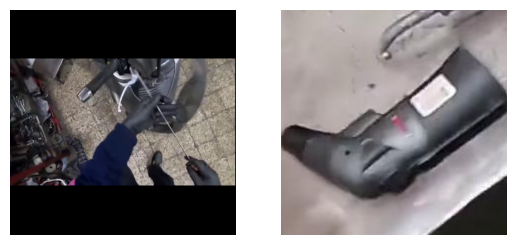

In [50]:
transform = torchvision.transforms.ToPILImage()

clip_origin = sample['clip_origin']
frame = (clip_origin[batch_i, frame_i])  # [b,t,c,h,w] -> [c,h,w]
frame = transform(frame)
query_origin = sample['query_origin']
query_img = (query_origin[batch_i])  # [c,h,w]
query_img = transform(query_img)
frame = np.asarray(frame)
query_img = np.asarray(query_img)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
axs[0].imshow(frame)
axs[0].axis('off')
axs[1].imshow(query_img)
axs[1].axis('off')
plt.show()

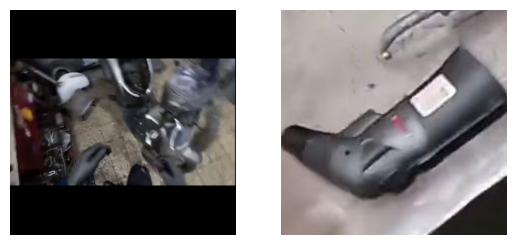

In [40]:
import matplotlib.pyplot as plt
import cv2

fig, axs = plt.subplots(1, 2)
axs[0].imshow(frame)
axs[0].axis('off')
axs[1].imshow(query_img)
axs[1].axis('off')
def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x = int(event.xdata)
        y = int(event.ydata)
        frame1_img_mark = cv2.circle(frame.copy(), (x, y), 9, (0, 0, 1.0), -1)
        
        select_pixel_x = int(event.xdata * 32 / frame.shape[1])
        select_pixel_y = int(event.ydata * 32 / frame.shape[0])
        select_aff = aff[select_pixel_y, select_pixel_x]
        axs[0].imshow(frame1_img_mark)
        axs[0].axis('off')
        axs[1].imshow(query_img)
        axs[1].imshow(select_aff, alpha=0.5)
        axs[1].axis('off')
        plt.draw()
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()